# Interpretable link prediction using SHAP + Neo4J

In the realm of network science, link prediction plays a pivotal role in forecasting future connections within a graph, unveiling latent relationships, and enhancing our understanding of complex systems. A graph, consisting of nodes representing entities and edges representing relationships, encapsulates intricate structures found in diverse domains such as social networks, biological systems, and information networks. Link prediction seeks to anticipate missing or potential edges between nodes, thereby contributing to predictive analytics, recommender systems, and the identification of evolving patterns in dynamic networks.

The task of link prediction is often accompanied by challenges, including the sparsity of real-world graphs, noise, and the need for interpretable models. As the predictive accuracy of link prediction models improves, the interpretability of these models becomes increasingly crucial. Understanding the rationale behind predicted links facilitates trust, aids decision-making, and enables the extraction of meaningful insights from the model's predictions.

Interpretability in link prediction involves unraveling the factors and features influencing the model's predictions. This is particularly relevant in applications where human intuition and domain knowledge are essential, as the interpretability of the model allows stakeholders to comprehend the basis for predicted connections. Furthermore, interpretable models provide a foundation for refining and validating the model's predictions, making them more aligned with real-world phenomena.

In this context, interpretability goes beyond mere accuracy metrics, delving into the transparency of the model's decision-making process. It involves identifying the key features, understanding their significance, and elucidating the model's decision pathways. Achieving interpretability in link prediction is not only a matter of improving model performance but also of building models that are accessible and comprehensible to domain experts and end-users.

### General set-up

In [1]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [2]:
import shap
from xgboost import XGBClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Creating the co-author graph

In [3]:
graph = Graph("bolt://localhost:7687", auth=("novoadmin", "novoadmin123"))

In [4]:
query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, paper
   ORDER BY a1, paper.year
   RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations", 
  {batchSize: 100})
"""

graph.run(query).data()

[{'batches': 3105,
  'total': 310448,
  'timeTaken': 2,
  'committedOperations': 310448,
  'failedOperations': 0,
  'failedBatches': 0,
  'retries': 0,
  'errorMessages': {},
  'batch': {'total': 3105, 'errors': {}, 'committed': 3105, 'failed': 0},
  'operations': {'total': 310448,
   'errors': {},
   'committed': 310448,
   'failed': 0},
  'wasTerminated': False,
  'failedParams': {},
  'updateStatistics': {'relationshipsDeleted': 0,
   'relationshipsCreated': 0,
   'nodesDeleted': 0,
   'nodesCreated': 0,
   'labelsRemoved': 0,
   'labelsAdded': 0,
   'propertiesSet': 310448}}]

### Train-test split in graphs and positive examples

Data leakage occurs when the model inadvertently utilizes data beyond the training set, leading to unintended influences on the model's creation. Graph data introduces a particular vulnerability to this issue, given that nodes in the training set may have connections to nodes in the test set.

When we calculate link prediction measures over the training set, these measures inherently encompass information from the test set, which we later employ to evaluate the model.

Our approach, instead, involves dividing the graph into training and test sub-graphs. If the graph incorporates a temporal dimension, this task becomes more straightforward, as we can delineate the graph at a specific point in time. The training set encompasses data from before this temporal point, while the test set encompasses data afterward.

Nevertheless, even with this strategy, achieving a perfect solution remains elusive. It is imperative to ensure that the overall network structure in both the training and test sub-graphs remains similar.

Consequently, pairs of nodes in our train and test datasets will possess relationships between them, constituting the positive examples in our Machine Learning model.

Given that the citation graph includes temporal information, we can construct train and test graphs by splitting the data based on a particular year. The next step involves determining the most suitable year for this division, contingent on the distribution of the first year in which co-authors collaborated.

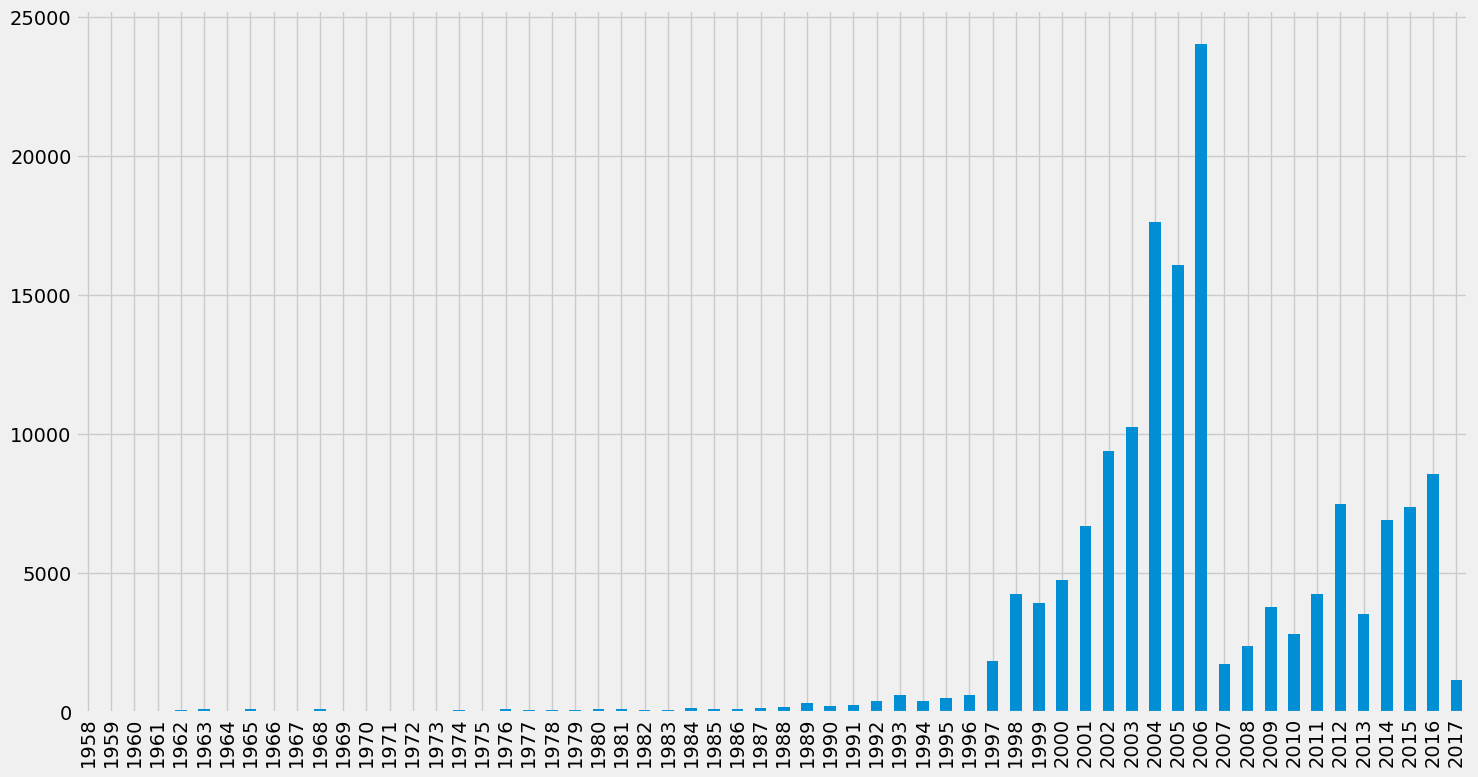

In [5]:
query = """
MATCH p=()-[r:CO_AUTHOR]->() 
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

It looks like 2006 would act as a good year for splitting the data. All co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.

In [6]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

graph.run(query).stats()

{}

In [7]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

graph.run(query).stats()

{}

In [8]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [9]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


### Understanding the negative examples

The most straightforward approach involves considering all pairs of nodes without a relationship. However, a significant drawback to this method lies in the substantial imbalance between examples of node pairs without a relationship and those with one.

The maximum count of negative examples can be expressed as:

> negative examples = (# nodes)² - (# relationships) - (# nodes)

In essence, this is the square of the number of nodes, subtracting the existing relationships in the graph and accounting for self-relationships.

Should we include all these negative examples in the training set, a massive class imbalance would arise, as there are numerous negative examples compared to relatively few positive ones. Consequently, a model trained on such imbalanced data would tend to predict that any pair of nodes lacks a relationship, leading to accuracy that doesn't align with our actual objectives.

To address this issue, it becomes imperative to decrease the number of negative examples. A common strategy, as outlined in various link prediction papers, involves selecting pairs of nodes that are a specific number of hops away from each other.

While this significantly diminishes the number of negative examples, a notable imbalance persists, albeit less pronounced than in the initial approach. To rectify this imbalance, a solution lies in either down-sampling the negative examples or up-sampling the positive ones, ensuring a more equitable distribution for effective model training.

In [10]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [11]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [12]:
train_missing_links.head()

,node1,node2,label
0,112,112,0
14,113,113,0
15,113,78846,0
16,113,78850,0
17,113,78849,0


In [13]:
train_existing_links.head()

,node1,node2,label
0,129,133,1
1,134,135,1
2,136,138,1
3,138,139,1
4,136,139,1


In [14]:
training_df = pd.concat([train_missing_links, train_existing_links], ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [15]:
training_df.head()

,node1,node2,label
1016879,121566,121574,1
229599,37340,207461,0
1023238,140707,140712,1
645686,135993,187085,0
1021811,7936,136595,1


In [16]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [17]:
test_df  = pd.concat([test_missing_links, test_existing_links], ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [18]:
test_df.head()

,node1,node2,label
1278453,39820,91034,1
1322216,63425,234596,1
291858,76014,60075,0
644793,160436,213376,0
107763,24462,143347,0


### Machine Learning Modeling

Here we are going to use XGBoost. XGBoost, or Extreme Gradient Boosting, is a powerful and efficient machine learning algorithm renowned for its exceptional performance in classification and regression tasks. Developed to improve upon traditional gradient boosting methods, XGBoost incorporates parallelization and regularization techniques, making it highly scalable and resistant to overfitting. Its success can be attributed to features such as tree pruning, column block selection, and a unique regularization term. XGBoost has become a popular choice in various data science competitions and real-world applications due to its speed, accuracy, and versatility, making it a go-to algorithm for boosting ensemble models.

In [19]:
classifier = XGBClassifier(max_depth=10, random_state=0)

Let's create some graphy features:


**Common neighbors** captures the idea that two strangers who have a friend in common are more likely to be introduced than those who don’t have any friends in common. It is computed by $CN(X,Y;0 = |N(X)\cap N(Y)|$

**Preferential attachment** means that the more connected a node is, the more likely it is to receive new links. This algorithm was popularised by Albert-László Barabási and Réka Albert through their work on scale-free networks. It is computed using the following formula: $PA(X, Y) = |N(X)| * |N(Y)|$

**Total Neighbors** computes the closeness of nodes, based on the number of unique neighbors that they have. It is based on the idea that the more connected a node is, the more likely it is to receive new links. It is computed by $TN(X,Y)=|N(X) \cup N(Y)|$



In [68]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [21]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

In [22]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,121566,121574,1,7.000,64.000,9.000
1,37340,207461,0,1.000,8.000,5.000
2,140707,140712,1,1.000,4.000,3.000
3,135993,187085,0,0.000,15.000,8.000
4,7936,136595,1,1.000,4.000,3.000


In [23]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [24]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,39820,91034,1,4.000,72.000,13.000
1,63425,234596,1,2.000,51.000,18.000
2,76014,60075,0,0.000,76.000,23.000
3,160436,213376,0,0.000,30.000,11.000
4,24462,143347,0,0.000,15.000,8.000


### Feature Importance

Feature importance and interpretability are crucial aspects in the field of machine learning, playing a pivotal role in understanding and trusting the models developed. As models become more complex and sophisticated, the need to interpret their decisions becomes increasingly important, especially in domains where decisions have significant real-world consequences.

Feature importance refers to the quantification of the impact of different features on the model's predictions. In simpler terms, it answers the question: "Which features contribute the most to the model's decision-making process?" Various algorithms, such as decision trees, random forests, and gradient boosting, provide ways to calculate feature importance. Understanding feature importance helps practitioners identify key factors driving the model's predictions, enabling them to focus on relevant variables and potentially improve model performance by eliminating irrelevant or redundant features.

As we are using XGBoost, this importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

In [69]:
def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

### Evaluating metrics

In this project, we have chosen accuracy, precision, and recall as our evaluating metrics due to their complementary roles in assessing the performance of our model. Accuracy provides a holistic measure of overall correctness, indicating the ratio of correctly predicted instances to the total number of instances. Precision, on the other hand, focuses on the accuracy of positive predictions, revealing the proportion of true positive predictions among all positive predictions made by the model. Recall, also known as sensitivity, emphasizes the model's ability to capture all relevant instances of the positive class by highlighting the ratio of true positive predictions to the total number of actual positive instances. By considering these metrics together, we gain a comprehensive understanding of our model's performance, balancing the trade-off between accurately identifying positive cases and minimizing false positives or negatives. This multi-faceted evaluation approach helps us make informed decisions about the model's effectiveness in meeting project objectives.

In [70]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

### Experiment 1

In the first experiment, let's train a model just using one column: the common neighbors feature.

In [25]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

,Measure,Score
0,Accuracy,0.854
1,Precision,0.943
2,Recall,0.753


'Feature Importance'

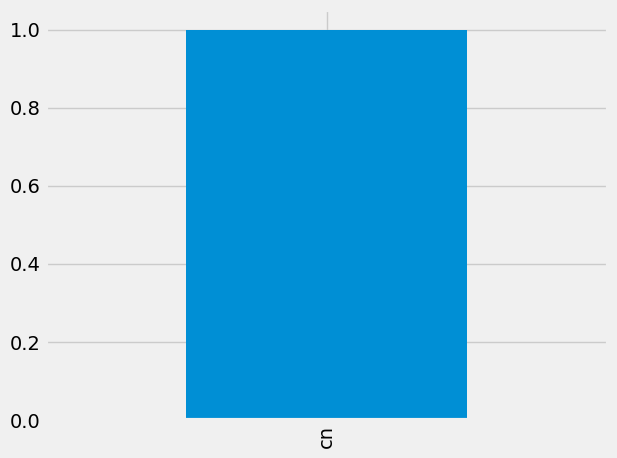

In [27]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The results for the first model indicate a reasonably strong performance with an accuracy of 85.4%. This metric reflects the overall correctness of the model's predictions. Additionally, the precision score of 94.3% suggests that when the model predicts a positive outcome, it is accurate more than 94% of the time. This high precision is indicative of a low rate of false positives. On the other hand, the recall score of 75% indicates that the model correctly identifies 75% of all actual positive instances. While this is a good result, it suggests that there is room for improvement in capturing a higher proportion of positive cases. So let's try with the other features.

### Experiment 2

,Measure,Score
0,Accuracy,0.918
1,Precision,0.918
2,Recall,0.917


'Feature Importance'

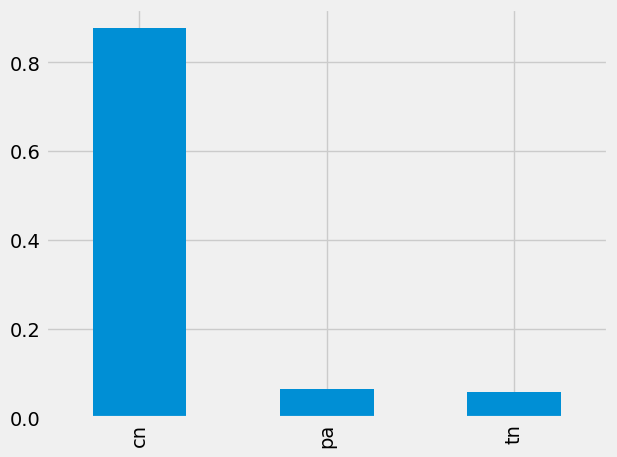

In [28]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Adding the two remaining columns, we observed a significant improvement in the results. However, we can see through the feature importance graph that the variable "Common Neighbors" remains the most crucial for our model.

### Storing the graph

We will reuse the same projected graphs multiple times during the workflow, so we will store it as a named graph in the graph catalog. We can project multiple relationship types and filter them at algorithm execution time. The following functions will project the named graph used later in the analysis. The relationships will be treated as undirected.

In [31]:
graph.run("""CALL gds.graph.project(
'coauthor',
'Author',
{CO_AUTHOR_EARLY: {orientation:'UNDIRECTED'},
CO_AUTHOR: {orientation:'UNDIRECTED'}}
);""").to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Author': {'label': 'Author', 'properties': {}}}","{'CO_AUTHOR_EARLY': {'aggregation': 'DEFAULT',...",coauthor,80299,472640,34


### Creating more features

Now, let's create two more types of features: 

**Triangle count**

The Triangle Count algorithm counts the number of triangles for each node in the graph. A triangle is a set of three nodes where each node has a relationship to the other two. In graph theory terminology, this is sometimes referred to as a 3-clique. The Triangle Count algorithm in the GDS library only finds triangles in undirected graphs.

Triangle counting has gained popularity in social network analysis, where it is used to detect communities and measure the cohesiveness of those communities. It can also be used to determine the stability of a graph, and is often used as part of the computation of network indices, such as clustering coefficients. The Triangle Count algorithm is also used to compute the Local Clustering Coefficient.

**Clustering Coefficient**

The Local Clustering Coefficient algorithm computes the local clustering coefficient for each node in the graph. The local clustering coefficient Cn of a node n describes the likelihood that the neighbours of n are also connected. To compute Cn we use the number of triangles a node is a part of Tn, and the degree of the node dn.

The formula of Clustering Coefficient is $$C_n = \frac{2 * T_{n}}{d_{n}(d_{n} - 1)}$$

In [32]:
graph.run("""
CALL gds.triangleCount.write('coauthor',
  {relationshipTypes:['CO_AUTHOR_EARLY'],
   writeProperty:'trianglesTrain'});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,20,80299,97205,80299,0,0,11,"{'writeProperty': 'trianglesTrain', 'jobId': '..."


In [33]:
graph.run("""
CALL gds.triangleCount.write('coauthor',
  {relationshipTypes:['CO_AUTHOR'],
   writeProperty:'trianglesTest'});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,22,80299,199813,80299,0,0,19,"{'writeProperty': 'trianglesTest', 'jobId': '3..."


In [34]:
graph.run("""
CALL gds.localClusteringCoefficient.write('coauthor',
  {relationshipTypes:['CO_AUTHOR_EARLY'],
   writeProperty:'coefficientTrain'});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,21,80299,0.375,80299,0,0,17,"{'writeProperty': 'coefficientTrain', 'triangl..."


In [35]:
graph.run("""
CALL gds.localClusteringCoefficient.write('coauthor',
  {relationshipTypes:['CO_AUTHOR'],
   writeProperty:'coefficientTest'});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,14,80299,0.657,80299,0,0,27,"{'writeProperty': 'coefficientTest', 'triangle..."


In [36]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

These measures are different than the ones we’ve used so far, because rather than being computed based on the pair of nodes, they are node specific measures. We can’t simply add these values to our DataFrame as node1Triangles or node1Coeff because we have no guarantee over the order of nodes in the pair. We need to come up with an approach that is agnostic of the order We can do this by taking the average of the values, the product of the values, or by computing the minimum and maximum value, as we do here.

In [37]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

So now we have this train and test datasets.

In [38]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,121566,121574,1,7.000,64.000,9.000,28,28,1.000,1.000
1,37340,207461,0,1.000,8.000,5.000,1,6,1.000,1.000
2,140707,140712,1,1.000,4.000,3.000,1,1,1.000,1.000
3,135993,187085,0,0.000,15.000,8.000,2,10,0.667,1.000
4,7936,136595,1,1.000,4.000,3.000,1,1,1.000,1.000


In [39]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,39820,91034,1,4.000,72.000,13.000,13,19,0.361,0.679
1,63425,234596,1,2.000,51.000,18.000,3,19,0.140,1.000
2,76014,60075,0,0.000,76.000,23.000,2,22,0.129,0.333
3,160436,213376,0,0.000,30.000,11.000,10,15,1.000,1.000
4,24462,143347,0,0.000,15.000,8.000,2,6,0.600,0.667


### Experiment 3

Now in experiment 3, we are going to use the graphy features and the triangle features.

,Measure,Score
0,Accuracy,0.956
1,Precision,0.949
2,Recall,0.964


'Feature Importance'

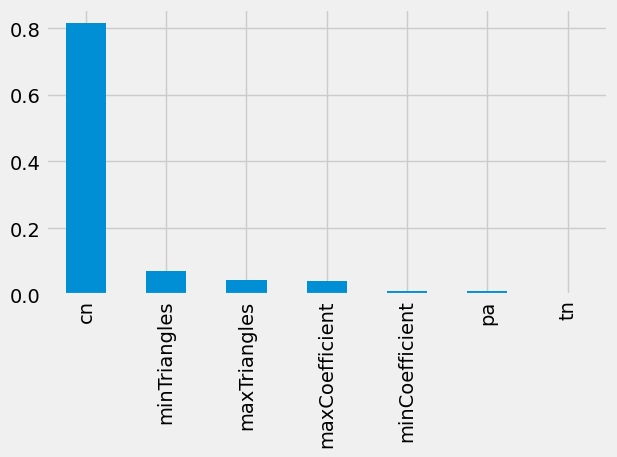

In [101]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

As we can see, we have once again observed an improvement in results, but the number of common neighbors remains the most crucial information for our model to perform classification.

### Creating the last features

Now, let's create some community features. Community Detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities.

We will run two Community Detection algorithms over the train and test sub-graphs - Label Propagation and Louvain. 

**Label Propagation:**

Objective: Semi-supervised node classification in networks.

Algorithm: Iterative label updates based on neighbors' majority.

Nature: Semi-supervised, requires initial labels.

Applications: Social networks, citation networks, bioinformatics.



**Louvain Algorithm:**

Objective: Unsupervised community detection in networks.

Algorithm: Optimizes modularity, iteratively moves nodes between communities.

Features: Reveals hierarchical community structure.

Applications: Social network analysis, biological networks.


In [41]:
graph.run("""
CALL gds.labelPropagation.write("coauthor",
  {relationshipTypes:["CO_AUTHOR_EARLY"],
   writeProperty: "partitionTrain"});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,14,80299,8,True,43827,"{'min': 1, 'p5': 1, 'max': 187, 'p999': 42, 'p...",6,0,46,"{'writeProperty': 'partitionTrain', 'nodeWeigh..."


In [42]:
graph.run("""
CALL gds.labelPropagation.write("coauthor",
  {relationshipTypes:["CO_AUTHOR"],
   writeProperty: "partitionTest"});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,16,80299,8,True,15838,"{'min': 1, 'p5': 1, 'max': 507, 'p999': 153, '...",6,0,56,"{'writeProperty': 'partitionTest', 'nodeWeight..."


In [43]:
graph.run("""
CALL gds.louvain.stream("coauthor",
  {relationshipTypes:["CO_AUTHOR_EARLY"],
   includeIntermediateCommunities:true})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

{'properties_set': 80299}

In [44]:
graph.run("""
CALL gds.louvain.stream("coauthor",
  {relationshipTypes:["CO_AUTHOR"],
   includeIntermediateCommunities:true})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

{'properties_set': 80299}

In [45]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    gds.alpha.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    gds.alpha.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [46]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [47]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,121566,121574,1,7.000,64.000,9.000,28,28,1.000,1.000,1.000,1.000
1,37340,207461,0,1.000,8.000,5.000,1,6,1.000,1.000,1.000,0.000
2,140707,140712,1,1.000,4.000,3.000,1,1,1.000,1.000,1.000,1.000
3,135993,187085,0,0.000,15.000,8.000,2,10,0.667,1.000,0.000,0.000
4,7936,136595,1,1.000,4.000,3.000,1,1,1.000,1.000,1.000,1.000


In [48]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,39820,91034,1,4.000,72.000,13.000,13,19,0.361,0.679,1.000,1.000
1,63425,234596,1,2.000,51.000,18.000,3,19,0.140,1.000,1.000,1.000
2,76014,60075,0,0.000,76.000,23.000,2,22,0.129,0.333,0.000,0.000
3,160436,213376,0,0.000,30.000,11.000,10,15,1.000,1.000,0.000,0.000
4,24462,143347,0,0.000,15.000,8.000,2,6,0.600,0.667,0.000,0.000


### Experiment 4

Now let's train our final model, using graphy features, traingle features and community features.

,Measure,Score
0,Accuracy,0.970
1,Precision,0.968
2,Recall,0.973


'Feature Importance'

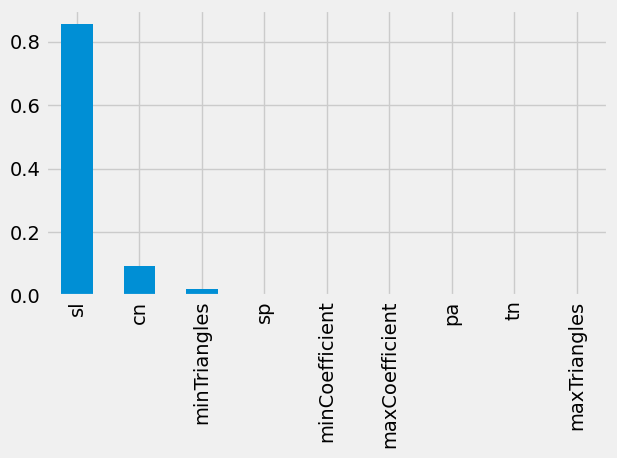

In [49]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Now we obtained the best results, the accuracy, precision and recall metrics were very good. These results demonstrate the robustness and reliability of our data science model, suggesting its potential for real-world applications with high precision and recall rates.

Now, we've had a significant change in the feature importance issue; currently, the most important variable is 'sl,' which in turn indicates whether a pair of nodes belongs to the same community according to the Louvain algorithm. This finding may have interesting implications for interpreting the results of your experiment. For instance, it may suggest that interactions and connections within communities are more influential for the analysis than the individual characteristics of the nodes. This also underscores the importance of considering the network structure and relationships between nodes when assessing the impact of different variables.

### Interpretability using SHAP

SHAP, or SHapley Additive exPlanations, is a powerful algorithmic framework used in machine learning for explaining the output of predictive models. Developed based on cooperative game theory concepts, SHAP values assign a unique contribution to each feature in a prediction, indicating its impact on the model's output. By providing interpretable insights into the model's decision-making process, SHAP helps users understand the importance of different input features and facilitates model transparency and trust. This interpretability is crucial for various applications, including explaining black-box models and ensuring accountability in decision-making processes.

In [91]:
shap.initjs()

In [93]:
explainer = shap.Explainer(classifier)
shap_values = explainer(training_df[columns]) 

### Global analysis

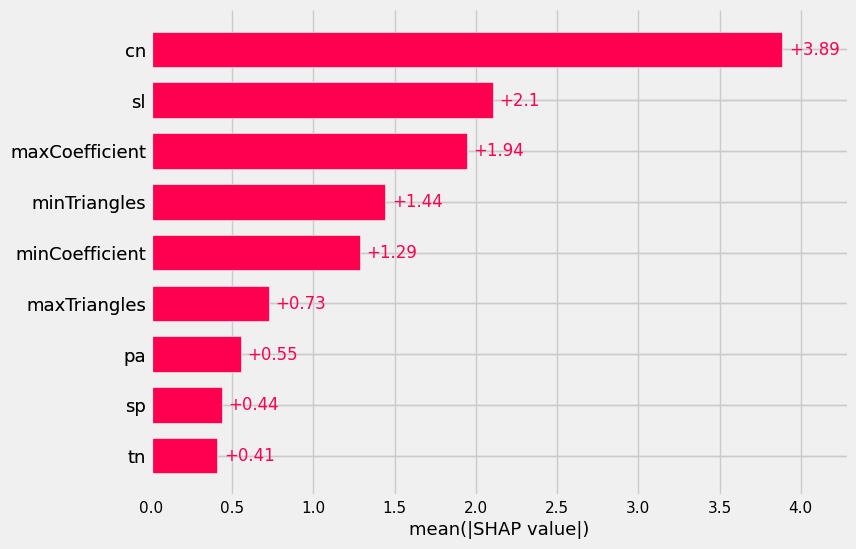

In [94]:
shap.plots.bar(shap_values)

Analyzing the most important variables according to SHAP, we observe a scenario quite different from the one using the traditional feature importance technique. Despite some finding this unusual, such a change is perfectly normal.

SHAP is a technique based on game theory that provides an approach for attributing individual contributions of features to the model's prediction. It can offer more detailed insights into how each variable contributes to predictions, taking into account interactions between variables.

On the other hand, traditional feature importance methods, such as calculating importance based on decision trees (as in the case of the Random Forest algorithm), may assign importance based on specific criteria, such as the reduction of impurity in tree splits.

In our case, we see that on average across all cases, the variable representing common neighbors remains the most impactful for model predictions, followed by the variable indicating whether a pair of nodes belongs to the same community according to the Louvain algorithm. Here, there is a greater importance of triangle variables in decision-making as well.

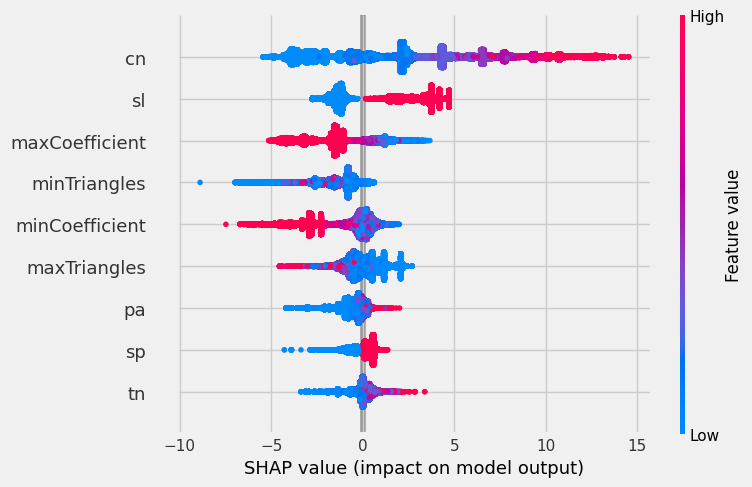

In [100]:
shap.summary_plot(shap_values, training_df[columns])

In this alternative visualization, we can observe how the impact on the model output varies depending on how low or high the value of a feature is. For instance, in the first feature, we observe that very high values tend to have a highly positive impact on the model output. 

However, for the minCoefficient and maxCoefficient variables, very high values tend to have a negative impact on the model output. This can be explained by that if, for example, A and B have a high local clustering coefficient and share many neighbors, they are less likely to form a direct link with each other because local connectivity is already being served by the shared neighbor nodes. . Nodes may prefer to connect to other nodes to expand their connections beyond the local cluster.

This behavior suggests that having a pair of nodes with many neighbors increases the likelihood of a link between them, and having a low clustering coefficient also increases this likelihood.

### Individual analysis

An advantage of using SHAP is that we can analyze the importance that each variable had in predicting the case of a single individual. This is extremely important when we talk about interpretability since a user can, according to the law, what led to an algorithmic decision making in relation to him. This detailed visualization also helps us identify atmospheric views in our algorithm.

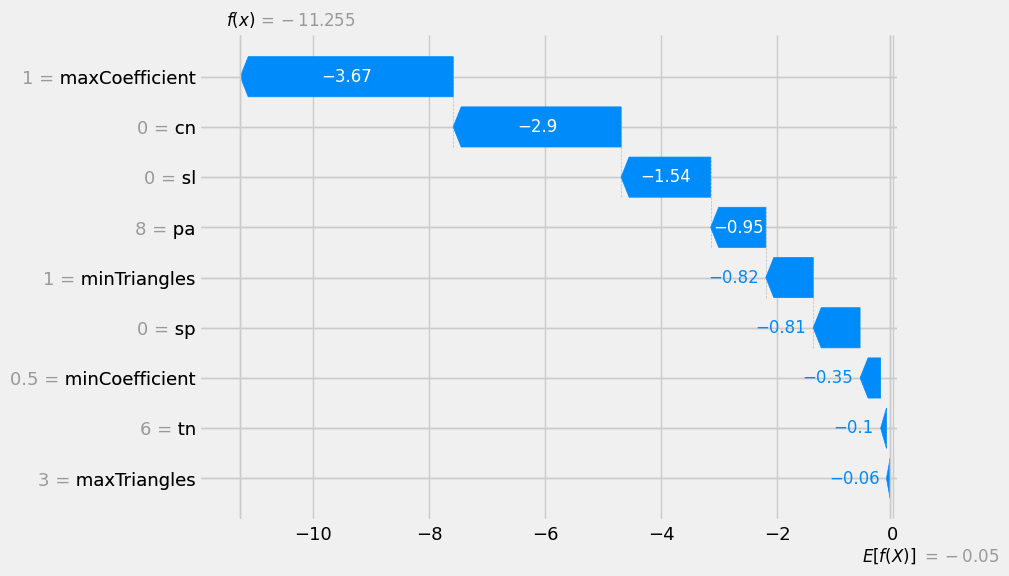

In [95]:
instance_index = 18
shap.plots.waterfall(shap_values[instance_index])

In this case, we can see that the fact that this pair of nodes has a high clustering coefficient, has 0 neighbors in common and also that they were not considered from the same community according to the Louvain algorithm were the three most important things to take the model to have a lower output.


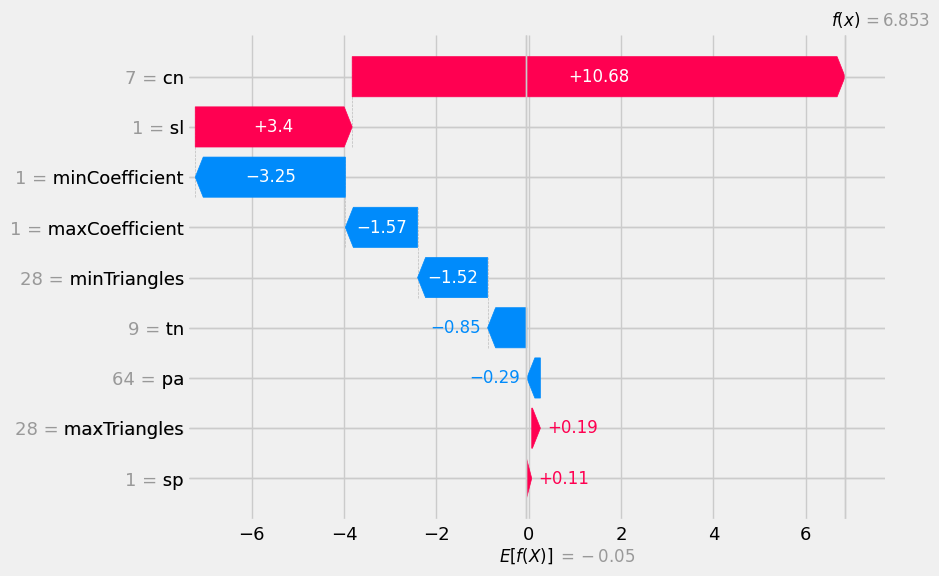

In [96]:
instance_index = 0
shap.plots.waterfall(shap_values[instance_index])

In this case, we can see that the fact that this pair of nodes have 7 neighbors in common and are considered part of the same community by the Louvain algorithm were the main causes for increasing the model's result. Some other variables played the opposite role, but thanks to the great impact of the high number of neighbors in common, the result ended up being more positive than expectance.

### Reseting the graph

In [99]:
graph.run("""
CALL gds.graph.drop('coauthor')
""").to_data_frame()

,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,coauthor,neo4j,local,,-1,80299,472640,{'relationshipProjection': {'CO_AUTHOR_EARLY':...,0.000,2024-02-29T10:55:15.295734300+00:00,2024-02-29T10:55:15.331739300+00:00,"{'graphProperties': {}, 'nodes': {'Author': {}...","{'graphProperties': {}, 'nodes': {'Author': {}..."
